In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
with open('data/item_codes.yaml', 'r') as fin:
    ITEM_CODES = yaml.safe_load(fin)

cohorts = pd.read_parquet('data/hh-cohorts.parquet')
health = pd.read_parquet('data/health-indicators.parquet')
cons = pd.read_parquet('data/baskets-consumption-value.parquet')
mult = pd.read_parquet('data/hh_details.parquet')['multiplier']

In [2]:
health = health.loc[cohorts.index]
hosp = health[health['is_hospitalization'] != 4]
hosp['cohort_id'] = cohorts['cohort_id']
hosp['multiplier'] = mult.loc[hosp.index]

cons = cons.loc[hosp.index]
df = pd.concat([hosp, cons], axis=1, verify_integrity=True)

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_75300/291583521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['cohort_id'] = cohorts['cohort_id']
/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_75300/291583521.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hosp['multiplier'] = mult.loc[hosp.index]


In [3]:
df.head()

,is_hhmem_pmjay,is_hospitalization,is_benefit_healthscheme,cohort_id,multiplier,71,72,140,141,142,...,36,37,97,99,432,630,631,632,633,639
hhid,,,,,,,,,,,,,,,,,,,,,
46626302,1,1,2.0,81,141124,NaN,NaN,50.0,60.0,NaN,...,NaN,NaN,NaN,1500.0,1500.0,NaN,NaN,NaN,NaN,NaN
46626305,1,2,1.0,81,141124,NaN,NaN,NaN,60.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,NaN,NaN,1000.0
46626312,1,2,1.0,79,141124,NaN,NaN,NaN,NaN,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46626316,1,1,1.0,81,141124,NaN,NaN,50.0,NaN,120.0,...,NaN,NaN,NaN,1200.0,1200.0,NaN,NaN,NaN,NaN,NaN
46625201,1,3,2.0,81,151480,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,250.0,250.0,NaN,NaN,5500.0,NaN,5500.0


In [19]:
# Drop cohorts that contain only one kind of `is_hhmem_pmjay`
chs = df.groupby('cohort_id')['is_hhmem_pmjay'].nunique()
chs = chs[chs == 2]
df = df[df['cohort_id'].isin(chs.index)]

In [4]:
def food_basket(df):
    freq_mul, item_codes = np.array(ITEM_CODES['FOOD']).T
    cons_values = df[item_codes] * freq_mul.reshape(1, -1)
    return (cons_values.sum(axis=1) / 12 * df['multiplier']).sum() / df['multiplier'].sum()


def _default_basket(df, codes, norm=12):
    return (df[codes].sum(axis=1) / norm * df['multiplier']).sum() / df['multiplier'].sum()

def edu_basket(df):
    item_codes = ITEM_CODES['EDUCATION']
    return _default_basket(df, item_codes)

def health_basket(df):
    item_codes = ITEM_CODES['HEALTH']
    return _default_basket(df, item_codes)

def utilities_basket(df):
    item_codes = ITEM_CODES['UTILITIES']
    return _default_basket(df, item_codes, norm=1)

def assets_basket(df):
    item_codes = ITEM_CODES['ASSETS']
    return _default_basket(df, item_codes)

In [20]:
def get_baskets(df):
    return pd.Series({
        'food': food_basket(df),
        'health': health_basket(df),
        'education': edu_basket(df),
        'utilities': utilities_basket(df),
        'assets': assets_basket(df)
    })

baskets = df.groupby(['cohort_id', 'is_hhmem_pmjay']).apply(get_baskets)

/var/folders/nz/p2j_7wnx56q0b61h97fxmmv40000gn/T/ipykernel_75300/755135372.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baskets = df.groupby(['cohort_id', 'is_hhmem_pmjay']).apply(get_baskets)


In [56]:
baskets.head(10)

food       health    education    utilities  \
cohort_id is_hhmem_pmjay                                                        
79        1                9027.931386  1674.527554   787.547662  1650.735961   
          2               20562.844902  1425.289828   392.826769  1795.142492   
81        1               11254.747532  1276.875112  1199.522931  2047.045101   
          2               21626.287692  1292.205971   659.463300  1911.046027   
99        1                7546.585473  1223.598277   342.328292   991.208295   
          2                9455.172735   930.032623   528.143875  1255.754813   
100       1                9689.494910  1423.270992   776.615751  1423.123888   
          2               10267.443992  1387.293232   182.692147  1284.704294   
126       1               10199.060748  1275.532363   575.482424  1241.403002   
          2               12413.829551  1758.664407   910.114454  1288.945288   

                               assets  
cohort_id is_hhmem_pmjay               
79        1                818.028269  
          2               1264.616210  
81        1               1375.722925  
          2                919.293147  
99        1                906.630383  
          2               1472.258995  
100       1                947.484286  
          2               1144.379639  
126       1               1445.912806  
          2               1766.385957

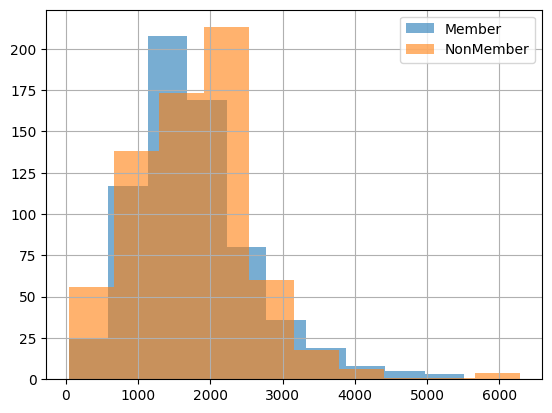

In [61]:
hdf = baskets['health'].reset_index()
ax = hdf[hdf['is_hhmem_pmjay'] == 1]['health'].hist(alpha=0.6, label="Member")
hdf[hdf['is_hhmem_pmjay'] == 2]['health'].hist(alpha=0.6, label="NonMember", ax=ax)
ax.legend()

In [65]:
treatment = hdf[hdf['is_hhmem_pmjay'] == 1]['health']
control = hdf[hdf['is_hhmem_pmjay'] == 2]['health']
from scipy.stats import ttest_ind

ttest_ind(
    control, treatment,
    alternative="greater",  # H1: mean(treatment) > mean(control)
    equal_var=False         # Welch’s t-test (recommended)
)

TtestResult(statistic=np.float64(0.6279427757067814), pvalue=np.float64(0.2650743006876125), df=np.float64(1337.7999739314744))

In [67]:
# At the level of all cohorts, this fails. For people who are hospitalized,
# it doesn't matter whether they are benficiaries or not. They both spend the same amount of money on health.

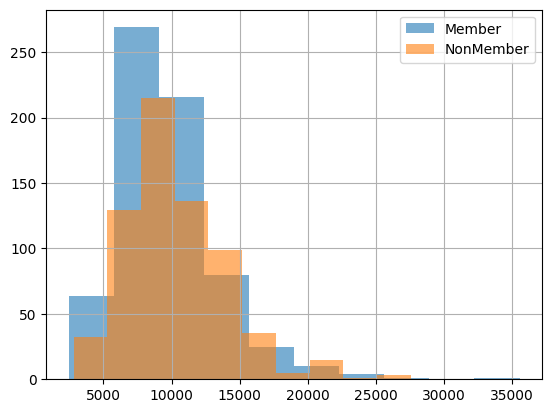

In [68]:
fdf = baskets['food'].reset_index()
ax = fdf[fdf['is_hhmem_pmjay'] == 1]['food'].hist(alpha=0.6, label="Member")
fdf[fdf['is_hhmem_pmjay'] == 2]['food'].hist(alpha=0.6, label="NonMember", ax=ax)
ax.legend()

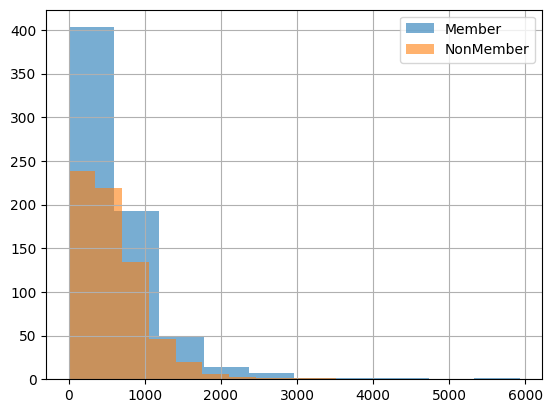

In [69]:
edf = baskets['education'].reset_index()
ax = edf[edf['is_hhmem_pmjay'] == 1]['education'].hist(alpha=0.6, label="Member")
edf[edf['is_hhmem_pmjay'] == 2]['education'].hist(alpha=0.6, label="NonMember", ax=ax)
ax.legend()

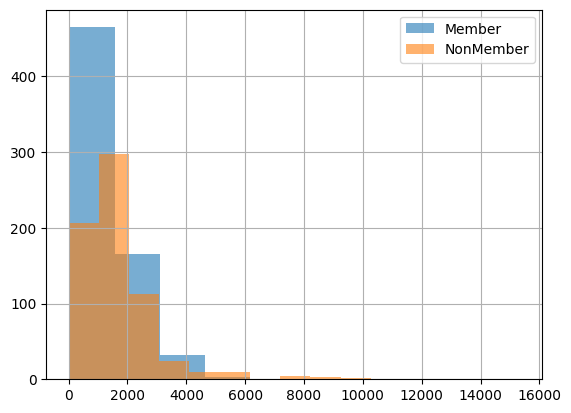

In [72]:
udf = baskets['assets'].reset_index()
ax = udf[udf['is_hhmem_pmjay'] == 1]['assets'].hist(alpha=0.6, label="Member")
udf[udf['is_hhmem_pmjay'] == 2]['assets'].hist(alpha=0.6, label="NonMember", ax=ax)
ax.legend()